## Semantic search with MAX Engine

Accompaning code for the Modular blog post TODO: link after publish

To get the data [Amazon Multilingual Counterfactual Dataset (AMCD)](https://github.com/amazon-science/amazon-multilingual-counterfactual-dataset) 

```sh
git clone https://github.com/amazon-science/amazon-multilingual-counterfactual-dataset
```

## Examine the dataset and tokenize the sentences

In [1]:
import pandas as pd

data = pd.read_csv("amazon-multilingual-counterfactual-dataset/data/EN_train.tsv", sep="\t")
print(f"data size: {data.shape}")
data.head()

data size: (4018, 2)


,sentence,is_counterfactual
0,In person it looks as though it would have cos...,1
1,Product received as described in the shipping ...,0
2,The handkerchiefs were just what I wanted - so...,0
3,I adore Nessa and give her credit because the...,0
4,He was very pleased when he saw how neat the c...,0


In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")
inputs = tokenizer(list(data['sentence']), return_tensors="pt", max_length=512, padding=True, truncation=True)

/home/ubuntu/workspace/max/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the ONNX version from HuggingFace

In [ ]:
%%bash

git lfs install
git clone https://huggingface.co/BAAI/bge-base-en-v1.5

### Optional: Convert to ONNX from PyTorch using optimum

In [ ]:
## Use the provided onnx model or manually convert to onnx with optimum
# !optimum-cli export onnx --model "BAAI/bge-base-en-v1.5" "./onnx/bge-base-en-v1.5"

### MAX Engine inference

In [3]:
%%time

from max import engine

session = engine.InferenceSession()
maxmodel = session.load("bge-base-en-v1.5/onnx/model.onnx")

Compiling model.....
Done!


CPU times: user 764 ms, sys: 1.02 s, total: 1.78 s
Wall time: 7.6 s


In [11]:
for tensor in maxmodel.input_metadata:
    print(f'input name: {tensor.name}, shape: {tensor.shape}, dtype: {tensor.dtype}')

for tensor in maxmodel.output_metadata:
    print(f'output name: {tensor.name}, shape: {tensor.shape}, dtype: {tensor.dtype}')

input name: input_ids, shape: [None, None], dtype: DType.int64
input name: attention_mask, shape: [None, None], dtype: DType.int64
input name: token_type_ids, shape: [None, None], dtype: DType.int64
output name: last_hidden_state, shape: [None, None, 768], dtype: DType.float32


In [12]:
%%time

from torch.utils.data import DataLoader, TensorDataset

ds = TensorDataset(inputs["input_ids"], inputs["token_type_ids"], inputs["attention_mask"])
data_loader = DataLoader(ds, batch_size=128, shuffle=False)
output_embeddings = []

for batch in data_loader:
    batch_input_ids, batch_token_type_ids, batch_attention_mask = batch
    batch_outputs = maxmodel.execute(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)
    last_hidden_state = batch_outputs["last_hidden_state"]
    # Extract the CLS token embedding
    sentence_embeddings = last_hidden_state[:, 0, :]
    output_embeddings.append(sentence_embeddings)

CPU times: user 15min 31s, sys: 15.5 s, total: 15min 47s
Wall time: 42.1 s


In [13]:
import numpy as np

all_embeddings = np.concatenate(output_embeddings, axis=0)
print(f"All embeddings dimensions: {all_embeddings.shape}")

All embeddings size: (4018, 768)


### Vector Database

* Create client and collection
* Store the embeddings with their metadata
* Test query
* Assess accuracy, f1-score, precision and recall

In [14]:
import chromadb

chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="counterfactual_collection", metadata={"hnsw:space": "cosine"})

In [15]:
%%time

for i, (documents, embeddings, label) in enumerate(zip(list(data['sentence']), all_embeddings.tolist(), list(data['is_counterfactual']))):
    collection.upsert(ids=[str(i)], documents=documents, embeddings=embeddings, metadatas=[{"is_counterfactual": label}])

CPU times: user 5.25 s, sys: 76.1 ms, total: 5.32 s
Wall time: 5.28 s


In [16]:
query = "I've worn my boots a couple times without proper socks and I can definitely tell the difference!"
query_inputs = tokenizer(query, return_tensors="np", max_length=512, padding=True, truncation=True)
query_output = maxmodel.execute(input_ids=query_inputs["input_ids"], token_type_ids=query_inputs["token_type_ids"], attention_mask=query_inputs["attention_mask"])
# Extract the CLS token embedding
query_embeddings = query_output["last_hidden_state"][:, 0, :]
results = collection.query(query_embeddings, n_results=10)
counterfactual_prob = sum([r["is_counterfactual"] for r in results["metadatas"][0]]) / len(results["metadatas"][0])
print(f"counterfactual probability for query='{query}' is {counterfactual_prob * 100}%")

counterfactual probability for query='I've worn my boots a couple times without proper socks and I can definitely tell the difference!' is 10.0%


In [17]:
%%time

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

test_data = pd.read_csv("amazon-multilingual-counterfactual-dataset/data/EN_test.tsv", sep="\t")
cutoff_threshold = 0.5

def get_counterfactual_prob(sentence):
    query_inputs = tokenizer(sentence, return_tensors="np", max_length=512, padding=True, truncation=True)
    query_output = maxmodel.execute(input_ids=query_inputs["input_ids"], token_type_ids=query_inputs["token_type_ids"], attention_mask=query_inputs["attention_mask"])
    # Extract the CLS token embedding
    query_embeddings = query_output["last_hidden_state"][:, 0, :]
    results = collection.query(query_embeddings, n_results=10)
    counterfactual_prob = sum([r["is_counterfactual"] for r in results["metadatas"][0]]) / len(results["metadatas"][0])
    return counterfactual_prob

predictions = []
for index, row in test_data.iterrows():
    counterfactual_prob = get_counterfactual_prob(row['sentence'])
    prediction = 1 if counterfactual_prob > cutoff_threshold else 0
    predictions.append(prediction)

accuracy = accuracy_score(test_data['is_counterfactual'], predictions)
f1 = f1_score(test_data['is_counterfactual'], predictions)
precision = precision_score(test_data['is_counterfactual'], predictions)
recall = recall_score(test_data['is_counterfactual'], predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.88
F1 Score: 0.64
Precision: 0.75
Recall: 0.56
CPU times: user 2min 34s, sys: 691 ms, total: 2min 35s
Wall time: 7.52 s


### MAX Engine performance comparision against PyTorch

In [4]:
import gc
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
from transformers import AutoModel
from optimum.onnxruntime import ORTModelForFeatureExtraction

model = AutoModel.from_pretrained("BAAI/bge-base-en-v1.5")
model.eval()

ortmodel = ORTModelForFeatureExtraction.from_pretrained('BAAI/bge-large-en-v1.5', revision="refs/pr/13",file_name="onnx/model.onnx")

def measure_runtime(inputs, model_fn, batch_sizes, is_pytorch=True):
    results = {}
    ds = TensorDataset(inputs["input_ids"], inputs["token_type_ids"], inputs["attention_mask"])
    for batch_size in batch_sizes:
        data_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
        times = []
        for batch in data_loader:
            start_time = time.time()
            batch_input_ids, batch_token_type_ids, batch_attention_mask = batch
            if is_pytorch:
                with torch.no_grad():
                    _ = model_fn(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)
            else:
                _ = model_fn(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)

            end_time = time.time()
            times.append(end_time - start_time)

        gc.collect()
        times = np.array(times)
        mean_time = np.mean(times)
        std_time = np.std(times)
        # 95% confidence interval with normality distribution assumption of time measurements
        confidence_interval = 1.96 * (std_time / np.sqrt(len(times)))
        results[batch_size] = {'mean_time': mean_time, 'std_time': std_time, 'confidence_interval': confidence_interval}

    return results

2024-03-21 18:44:39.944245: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 18:44:40.048462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 18:44:40.748565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 18:44:42.610115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The ONNX file onnx/model.onnx is not a regular name used in optimum.onnxruntime, the ORTModel might not behave as 

### Smaller batch sizes up to 32

In [18]:
small_batch_sizes = [2 ** i for i in range(6)]

small_results = measure_runtime(inputs, model, small_batch_sizes)
small_results

{1: {'mean_time': 0.025724823644589643,
  'std_time': 0.0011195150605967576,
  'confidence_interval': 3.4616331849532786e-05},
 2: {'mean_time': 0.03914655364526926,
  'std_time': 0.001375384256103066,
  'confidence_interval': 6.0143701329033785e-05},
 4: {'mean_time': 0.06768541691908196,
  'std_time': 0.002410854367494715,
  'confidence_interval': 0.0001490541311071916},
 8: {'mean_time': 0.10459894072227402,
  'std_time': 0.004060433963336759,
  'confidence_interval': 0.0003548497720538892},
 16: {'mean_time': 0.22655597754887172,
  'std_time': 0.019549933744319445,
  'confidence_interval': 0.0024137989323120886},
 32: {'mean_time': 0.45170678032769096,
  'std_time': 0.029710609404862427,
  'confidence_interval': 0.005187789653445412}}

In [19]:
small_maxresults = measure_runtime(inputs, lambda **kwargs: maxmodel.execute(**kwargs), small_batch_sizes, is_pytorch=False)
small_maxresults

{1: {'mean_time': 0.016388452189546605,
  'std_time': 0.0009159324236330689,
  'confidence_interval': 2.832138829050514e-05},
 2: {'mean_time': 0.02863428710170383,
  'std_time': 0.004601834935480284,
  'confidence_interval': 0.0002012320445700227},
 4: {'mean_time': 0.04515657994284559,
  'std_time': 0.006237700666856768,
  'confidence_interval': 0.00038565376056756917},
 8: {'mean_time': 0.0807397962801499,
  'std_time': 0.010892486148613432,
  'confidence_interval': 0.0009519170270557248},
 16: {'mean_time': 0.15243395074965463,
  'std_time': 0.014727026202710044,
  'confidence_interval': 0.0018183222812487917},
 32: {'mean_time': 0.322895400107853,
  'std_time': 0.03761707250495685,
  'confidence_interval': 0.006568342536325861}}

In [20]:
small_ortresults = measure_runtime(inputs, ortmodel, small_batch_sizes, is_pytorch=False)
small_ortresults

{1: {'mean_time': 0.12238260588876165,
  'std_time': 0.00031137254110870903,
  'confidence_interval': 9.627896569882538e-06},
 2: {'mean_time': 0.23233708628022653,
  'std_time': 0.0005314384798769582,
  'confidence_interval': 2.3239089052129114e-05},
 4: {'mean_time': 0.4630241882741748,
  'std_time': 0.007379263749761262,
  'confidence_interval': 0.0004562323470307556},
 8: {'mean_time': 0.8765397635890285,
  'std_time': 0.02878823666130272,
  'confidence_interval': 0.0025158638976366587},
 16: {'mean_time': 1.827323609874362,
  'std_time': 0.10069984190659804,
  'confidence_interval': 0.012433247808257676},
 32: {'mean_time': 3.6864752712703885,
  'std_time': 0.1455781407848308,
  'confidence_interval': 0.025419497871617684}}

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plot_performance_comparison(batch_sizes, results_with_labels, title):
    plt.figure(figsize=(10, 6))

    for label, res in results_with_labels:
        mean_times = [res[bs]['mean_time'] for bs in batch_sizes]
        conf_intervals = [res[bs]['confidence_interval'] for bs in batch_sizes]
        plt.errorbar(batch_sizes, mean_times, yerr=conf_intervals, fmt='-o', capsize=5, label=label)

    plt.xlabel('Batch Size')
    plt.ylabel('Mean Time (seconds)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

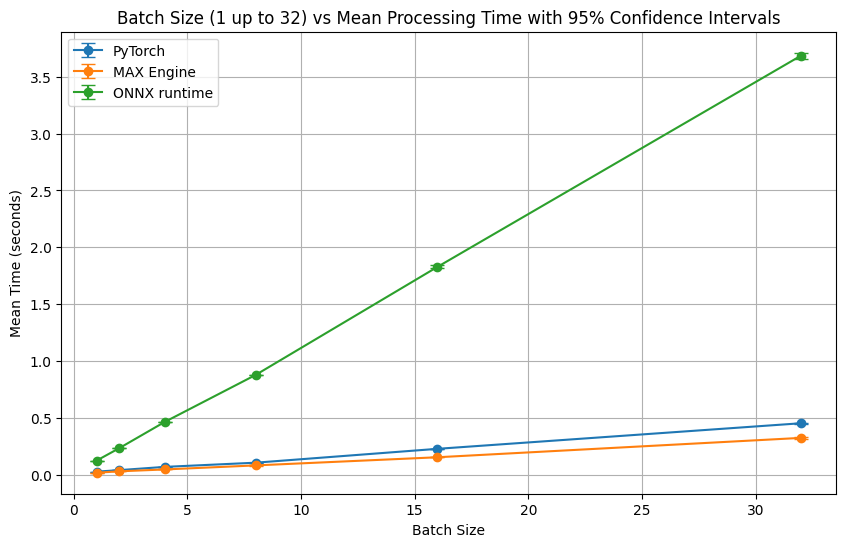

In [21]:
plot_performance_comparison(small_batch_sizes,
                            [("PyTorch", small_results),
                             ("MAX Engine", small_maxresults),
                             ("ONNX runtime", small_ortresults)],
                            title="Batch Size (1 up to 32) vs Mean Processing Time with 95% Confidence Intervals")

In [22]:
for b in small_batch_sizes:
    print(f"batch size {b}  MAX speedup against PT eager {small_results[b]['mean_time'] / small_maxresults[b]['mean_time']:.3}")
    print(f"batch size {b} MAX speedup against ORT speedup {small_ortresults[b]['mean_time'] / small_maxresults[b]['mean_time']:.3}")
    print("=" * 50)

batch size 1  MAX speedup against PT eager 1.57
batch size 1 MAX speedup against ORT speedup 7.47
batch size 2  MAX speedup against PT eager 1.37
batch size 2 MAX speedup against ORT speedup 8.11
batch size 4  MAX speedup against PT eager 1.5
batch size 4 MAX speedup against ORT speedup 10.3
batch size 8  MAX speedup against PT eager 1.3
batch size 8 MAX speedup against ORT speedup 10.9
batch size 16  MAX speedup against PT eager 1.49
batch size 16 MAX speedup against ORT speedup 12.0
batch size 32  MAX speedup against PT eager 1.4
batch size 32 MAX speedup against ORT speedup 11.4


### Larger batch size: 64 up to 4096

Caveat: ONNX Runtime can not handle large batch sizes

In [5]:
large_batch_sizes = [2 ** i for i in range(6, 13)]

large_results = measure_runtime(inputs, model, large_batch_sizes)
large_results

{64: {'mean_time': 1.1635253770010812,
  'std_time': 0.06451019416228201,
  'confidence_interval': 0.015929940206309633},
 128: {'mean_time': 2.7000724375247955,
  'std_time': 0.32799640376266626,
  'confidence_interval': 0.11364495583963724},
 256: {'mean_time': 5.232172220945358,
  'std_time': 0.39103216889516235,
  'confidence_interval': 0.19160576275862953},
 512: {'mean_time': 10.194679498672485,
  'std_time': 0.5967861291580313,
  'confidence_interval': 0.4135516884688004},
 1024: {'mean_time': 19.829804956912994,
  'std_time': 0.6745672150864245,
  'confidence_interval': 0.661075870784696},
 2048: {'mean_time': 39.542428493499756,
  'std_time': 0.8096575736999512,
  'confidence_interval': 1.1221281471724733},
 4096: {'mean_time': 79.20335650444031,
  'std_time': 0.0,
  'confidence_interval': 0.0}}

In [6]:
large_maxresults = measure_runtime(inputs, lambda **kwargs: maxmodel.execute(**kwargs), large_batch_sizes, is_pytorch=False)
large_maxresults

{64: {'mean_time': 0.6351379742698063,
  'std_time': 0.02000868621852881,
  'confidence_interval': 0.004940880727566242},
 128: {'mean_time': 1.305235043168068,
  'std_time': 0.14677618593599698,
  'confidence_interval': 0.050855353832100096},
 256: {'mean_time': 2.6512993425130844,
  'std_time': 0.21237153076868487,
  'confidence_interval': 0.10406205007665559},
 512: {'mean_time': 5.4555279314517975,
  'std_time': 0.33311288367088654,
  'confidence_interval': 0.23083545136540362},
 1024: {'mean_time': 11.869774401187897,
  'std_time': 0.8275278594046777,
  'confidence_interval': 0.810977302216584},
 2048: {'mean_time': 25.930068731307983,
  'std_time': 1.6367738246917725,
  'confidence_interval': 2.2684527865880595},
 4096: {'mean_time': 54.694310426712036,
  'std_time': 0.0,
  'confidence_interval': 0.0}}

In [ ]:
## ONNX Runtime can not handle large batch sizes

# large_ortresults = measure_runtime(inputs, ortmodel, large_batch_sizes, is_pytorch=False)
# large_ortresults

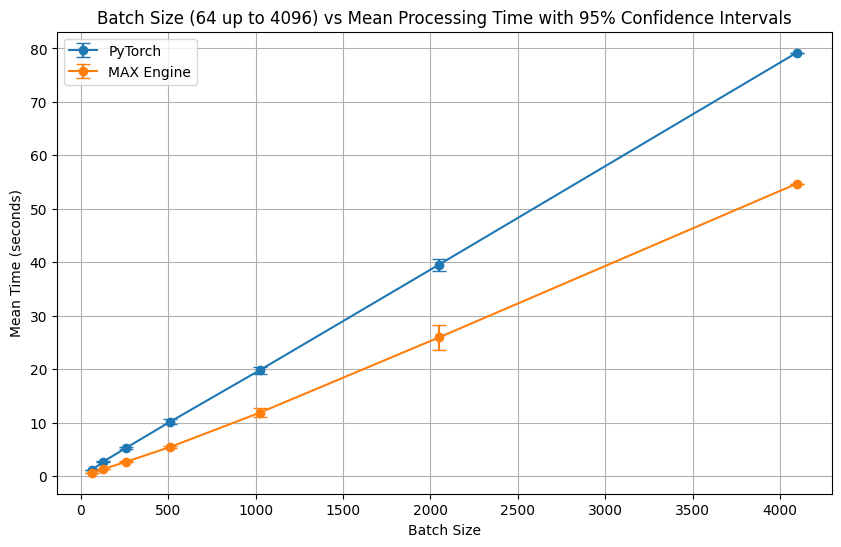

In [9]:
plot_performance_comparison(large_batch_sizes,
                            [("PyTorch", large_results),
                             ("MAX Engine", large_maxresults)],
                            title="Batch Size (64 up to 4096) vs Mean Processing Time with 95% Confidence Intervals")

In [10]:
for b in large_batch_sizes:
    print(f"batch size {b}  MAX speedup against PT eager {large_results[b]['mean_time'] / large_maxresults[b]['mean_time']:.3}")
    print("=" * 50)

batch size 64  MAX speedup against PT eager 1.83
batch size 128  MAX speedup against PT eager 2.07
batch size 256  MAX speedup against PT eager 1.97
batch size 512  MAX speedup against PT eager 1.87
batch size 1024  MAX speedup against PT eager 1.67
batch size 2048  MAX speedup against PT eager 1.52
batch size 4096  MAX speedup against PT eager 1.45
